In [1]:
# Auxiliary variable embedding LDA model
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import torch
import torch.nn as nn
import torch.optim as optimizers
from scipy import sparse
from scipy.stats import norm
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
# 多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

# 切断ポアソン分布を生成する関数
def rtpois(mu, a, b, n, flag=0):
    FA = scipy.stats.poisson.cdf(a, mu)
    FB = scipy.stats.poisson.cdf(b, mu)
    x = np.array(scipy.stats.poisson.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu), dtype="int")
    if flag==1:
        x = torch.Tensor(x)
    return x

# 切断ポアソン分布を高速で生成する関数
def rtpois_lw(mu, a, b, N, flag=0):
    x = np.random.poisson(mu, N)
    index = np.where(x==0)[0]
    x[index] = rtpois(mu[index], a, b, index.shape[0], 0)
    if flag==1:
        x = torch.Tensor(x)
    return x

# ガンマ分布を生成する関数
def Gamma(w1, w2, n):
    if n==0:
        x = torch.Tensor(np.random.gamma(w1, w2))
    else:
        x = torch.Tensor(np.random.gamma(w1, w2, n))
    return x

# 二項分布を生成する関数
def Binomial(m, prob, n):
    x = torch.Tensor(np.random.binomial(1, Prob.numpy(), F))
    return x

# データの生成

In [3]:
# データの設定
k = 15
d = 3000
w = 2500
Lambda1 = np.random.gamma(30.0, 1/0.25, w)
Lambda2 = np.random.gamma(50.0, 1/0.2, d)
f1 = np.random.poisson(Lambda1, w)
pt = np.random.poisson(Lambda2, d)
F = np.sum(f1)
N = np.sum(pt)
k_vec = np.repeat(1.0, k)

In [4]:
# IDとインデックスを作成
# IDの定義
wd1 = np.repeat(np.arange(w), f1)
d_id = np.repeat(np.arange(d), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(d)])))

# インデックスの定義
w_list1 = [i for i in range(w)]
d_list = [i for i in range(d)]
for i in range(w):
    w_list1[i] = np.array(np.where(wd1==i)[0], dtype="int")
for i in range(d):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")

In [6]:
# wordの生成
# 多項分布からトピックを生成
topic = 30
theta_topic1 = np.random.dirichlet(np.repeat(0.2, topic), w)
theta_topic2 = np.random.dirichlet(np.repeat(0.2, topic), d)
phi_word = np.random.dirichlet(np.repeat(0.2, w), topic)
z1 = rmnom(theta_topic1[wd1, ], F, topic, 0)
z2 = rmnom(theta_topic2[d_id, ], N, topic, 0)

# トピックから共起wordを生成
wd2 = np.repeat(0, F)
for i in range(w):
    index = w_list1[i]
    words = rmnom(phi_word[z1[index], ], f1[i], w, 0)
    if np.sum(words==i)==0:
        wd2[index] = words
        next
    while True:
        index_dup = np.where(words==i)[0]
        words[index_dup] = rmnom(phi_word[z1[index][index_dup], ], index_dup.shape[0], w, 0)
        if np.sum(words==i)==0:
            wd2[index] = words
            break
            
# インデックスの定義
w_list2 = [i for i in range(w)]
f2 = np.repeat(0, w)
for i in range(w):
    w_list2[i] = np.array(np.where(wd2==i)[0], dtype="int")
    f2[i] = w_list2[i].shape[0]

# トピックから文書内wordを生成
word_id = np.repeat(0, N)
for i in range(d):
    index = d_list[i]
    word_id[index] = rmnom(phi_word[z2[index], ], pt[i], w, 0)
    
# インデックスの定義
word_list = [i for i in range(w)]
m = np.repeat(0, w)
for i in range(w):
    word_list[i] = np.array(np.where(word_id==i)[0], dtype="int")
    m[i] = word_list[i].shape[0]

In [7]:
# 応答変数の生成
rp = 0

while True:
    print(rp)
    rp += 1

    # パラメータの生成
    beta1 = np.random.gamma(10.0, 0.1, w)
    beta2 = np.random.gamma(5.0, 0.1, w)
    theta = np.random.gamma(0.1, 2.5, d*k).reshape(d, k)
    gamma = np.random.gamma(0.1, 2.25, w*k).reshape(w, k)
    omega1 = np.random.gamma(0.1, 1.5, k*k).reshape(k, k)
    omega2 = np.random.gamma(0.1, 2.5, k*k).reshape(k, k)
    betat1 = beta1.copy(); betat2 = beta2.copy()
    thetat = theta.copy(); gammat = gamma.copy(); omegat1 = omega1.copy(); omegat2 = omega2.copy()
    
    # 期待値を定義
    delta11 = beta1[wd1, np.newaxis] * gamma[wd1, ]
    delta12 = beta1[wd2, np.newaxis] * gamma[wd2, ]
    delta2 = beta2[word_id, np.newaxis] * gamma[word_id, ]
    mu1 = np.dot(np.dot(delta11, omega1) * delta12, k_vec)
    mu2 = np.dot(np.dot(theta[d_id, ], omega2) * delta2, k_vec)

    # ポアソン分布から応答変数を生成
    y1 = rtpois(mu1, 0, np.inf, F, 0)
    freq = np.random.poisson(mu2, N)
    y2 = np.array(freq > 0, dtype="int")
    
    if (np.max(y1) < 300) & (np.mean(y2) > 0.4) & (np.mean(y2) < 0.5):
        break

0
1
2
3
4


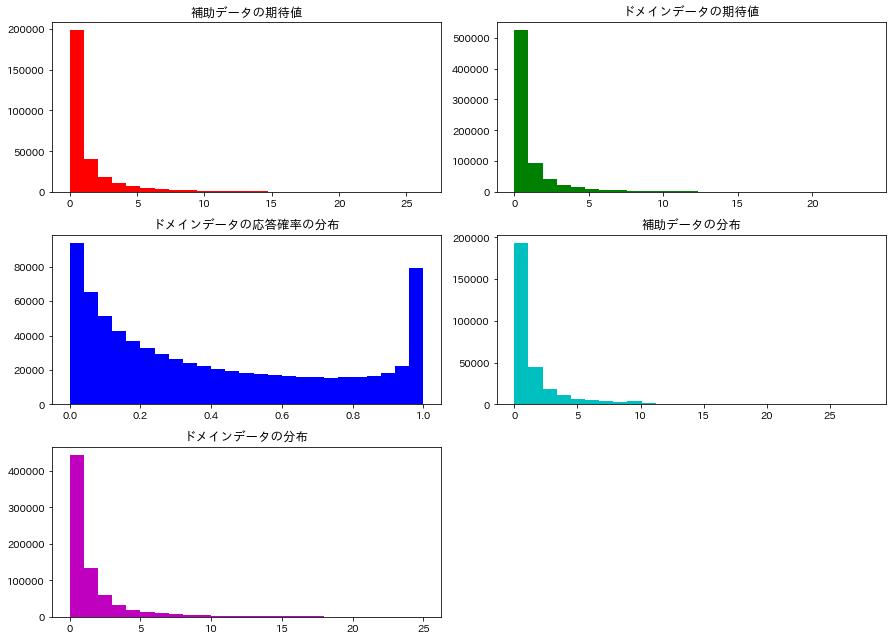

In [8]:
#生成したデータを可視化
q = 99.5
Prob = 1 - np.exp(-mu2)
dt = [mu1, mu2, Prob, y1, freq]
fig_range = np.append(np.repeat(0.0, len(dt)), 
                      np.array([np.percentile(mu1, q), np.percentile(mu2, q), 1.0, 
                                np.percentile(y1, q), np.percentile(freq, q)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["補助データの期待値", "ドメインデータの期待値", "ドメインデータの応答確率の分布", "補助データの分布", "ドメインデータの分布"]
fig = plt.figure(figsize=(12.5, 9.0))
for j in range(len(dt)):
    ax = fig.add_subplot(3, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

# Auxiliary variable embedding PFA modelを推定

In [9]:
# アルゴリズムの設定
R = 2000
keep = 2
burnin = 500
skeep = int(burnin/keep)
iters = 0
disp = 10

In [278]:
# データの定義
# 定数の定義
k_vec = torch.Tensor(np.repeat(1.0, k))
y1 = torch.Tensor(y1)
y2 = torch.Tensor(y2)
index_allocation1 = np.repeat(np.arange(k), k)
index_allocation2 = np.tile(np.arange(k), k)
index_y2 = np.array(np.where(y2 > 0)[0], dtype="int")
M = index_y2.shape[0]

# 新しいidを定義
d_id_ = d_id[index_y2]
word_id_ = word_id[index_y2]

# インデックスを定義
d_list_ = [i for i in range(d)]
word_list_ = [i for i in range(w)]
for i in range(d):
    d_list_[i] = np.array(np.where(d_id_==i)[0], dtype="int")
for i in range(w):
    word_list_[i] = np.array(np.where(word_id_==i)[0], dtype="int")

In [279]:
# 事前分布の設定
s1 = 5.0; v1 = 5.0
s2 = 0.1; v2 = 0.1
s3 = 0.25; v3 = 0.25 

In [285]:
# パラメータの真値
# モデルパラメータの真値
beta1 = torch.Tensor(betat1)
beta2 = torch.Tensor(betat2)
theta = torch.Tensor(thetat)
gamma = torch.Tensor(gammat)
omega1 = torch.Tensor(omegat1)
omega2 = torch.Tensor(omegat2)

# モデル期待値の真値
delta11 = (beta1[:, np.newaxis] * gamma)[wd1, ]
delta12 = (beta1[:, np.newaxis] * gamma)[wd2, ]
delta2 = (beta2[:, np.newaxis] * gamma)[word_id, ]
mu1 = torch.mv(torch.mm(delta11, omega1) * delta12, k_vec)
mu2 = torch.mv(torch.mm(theta, omega2)[d_id, ] * delta2, k_vec)
mut1 = mu1.clone()
mut2 = mu2.clone()

In [290]:
# パラメータの初期値
# モデルパラメータの初期値
beta1 = torch.Tensor(np.repeat(1.0, w))
beta2 = torch.Tensor(np.repeat(1.0, w))
theta = Gamma(0.5, 0.25, d*k).reshape(d, k)
gamma = Gamma(0.5, 0.25, w*k).reshape(w, k)
omega1 = Gamma(0.5, 0.25, k*k).reshape(k, k)
omega2 = Gamma(0.5, 0.25, k*k).reshape(k, k)

# モデル期待値の初期値
delta11 = (beta1[:, np.newaxis] * gamma)[wd1, ]
delta12 = (beta1[:, np.newaxis] * gamma)[wd2, ]
delta2 = (beta2[:, np.newaxis] * gamma)[word_id, ]
mu1 = torch.mv(torch.mm(delta11, omega1) * delta12, k_vec)
mu2 = torch.mv(torch.mm(theta, omega2)[d_id, ] * delta2, k_vec)

In [291]:
# パラメータの格納用配列
RS = np.arange(skeep, int(R/keep))
rs = RS.shape[0]
BETA1 = torch.zeros((rs, w))
BETA2 = torch.zeros((rs, w))
THETA = torch.zeros((d, k, rs))
GAMMA = torch.zeros((w, k, rs))
OMEGA1 = torch.zeros((k, k, rs))
OMEGA2 = torch.zeros((k, k, rs))

In [292]:
# 対数尤度の基準値
# 補助データの1パラメータモデルの対数尤度
Prob = 1 - torch.exp(-torch.mean(y1))
x = y1.numpy() * np.random.binomial(1, Prob.numpy(), F)
LLst1 = np.sum(scipy.stats.poisson.logpmf(x, np.mean(x)))
print(LLst1)

# 補助データの真値の対数尤度
Prob = 1 - torch.exp(-mut1)
x = y1.numpy() * np.random.binomial(1, Prob.numpy(), F)
LLbest1 = np.sum(scipy.stats.poisson.logpmf(x, mut1))
print(LLbest1)

# ドメインデータのユニグラムモデルの対数尤度
Prob = 1 - torch.exp(-torch.mean(y2))
LLst2 = torch.sum(y2*torch.log(Prob) + (1-y2)*torch.log(1-Prob)).numpy()
print(LLst2)

# 単語モデルの真値の対数尤度
Prob = 1 - torch.exp(-mut2)
Prob[Prob==1.0] = 0.9999999; Prob[Prob==0.0] = 10.0**-10
LLbest2 = torch.sum(y2*torch.log(Prob) + (1-y2)*torch.log(1-Prob)).numpy()
print(LLbest2)

-791136.4321316254
-313012.49280202086
-515628.56
-294133.34


In [293]:
# ギブスサンプリングでパラメータをサンプリング
for rp in range(R):

    # 潜在変数sをサンプリング
    # 期待値を定義
    uv_deploy11 = torch.mm(delta12, omega1.T) 
    uv_deploy12 = torch.mm(delta11, omega1) 
    mu_deploy11 = uv_deploy11 * delta11
    mu_deploy12 = uv_deploy12 * delta12
    mu1 = torch.sum(mu_deploy11, axis=1)

    # 潜在変数sから新しい変数を生成
    Prob = 1 - torch.exp(-mu1)
    s = Binomial(1, Prob.numpy(), F)
    x1 = s * y1

    # Bernoulli-Poisson linkで潜在頻度を生成
    uv_deploy2 = torch.mm(theta, omega2)[d_id, ] 
    mu_deploy2 = (uv_deploy2 * delta2)[index_y2, ]
    mu2 = torch.sum(mu_deploy2, axis=1)

    # 切断ポアソン分布から潜在頻度を生成
    xy2 = torch.zeros((N))
    x2 = rtpois_lw(mu2, 0, np.inf, M, 1)
    xy2[index_y2] = x2

    
    # 単語パラメータをサンプリング
    # 補助変数を定義
    lambda11 = mu_deploy11 / torch.sum(mu_deploy11, axis=1)[:, np.newaxis]
    lambda12 = mu_deploy12 / torch.sum(mu_deploy12, axis=1)[:, np.newaxis]
    lambda2 = mu_deploy2 / torch.sum(mu_deploy2, axis=1)[:, np.newaxis]

    # ガンマ分布の形状パラメータを定義
    lambda_y11 = x1[:, np.newaxis] * lambda11
    lambda_y12 = x1[:, np.newaxis] * lambda12
    lambda_y2 = x2[:, np.newaxis] * lambda2

    # ガンマ分布の尺度パラメータを定義
    lambda_b11 = torch.sum(uv_deploy11 * gamma[wd1, ], axis=1)
    lambda_b12 = torch.sum(uv_deploy12 * gamma[wd2, ], axis=1)
    lambda_b2 = torch.sum(uv_deploy2 * gamma[word_id, ], axis=1)
    lambda_g11 = uv_deploy11 * beta1[wd1, np.newaxis]
    lambda_g12 = uv_deploy12 * beta1[wd2, np.newaxis]
    lambda_g2 = uv_deploy2 * beta2[word_id, np.newaxis]

    # 事後分布のパラメータ
    w1 = torch.zeros((w, 2)); w2 = torch.zeros((w, 2))
    W1 = torch.zeros((w, k)); W2 = torch.zeros((w, k))
    for i in range(w):
        index11 = w_list1[i]; index12 = w_list2[i]
        index21 = word_list_[i]; index22 = word_list[i]
        w1[i, 0] = x1[index11].sum() + x1[index12].sum() + s1
        w2[i, 0] = lambda_b11[index11].sum() + lambda_b12[index12].sum() + v1
        w1[i, 1] = x2[index21].sum() + s1
        w2[i, 1] = lambda_b2[index22].sum() + v1
        W1[i, ] = lambda_y11[index11, ].sum(0) + lambda_y12[index12, ].sum(0) + lambda_y2[index21, ].sum(0) + s2
        W2[i, ] = lambda_g11[index11, ].sum(0) + lambda_g12[index12, ].sum(0) + lambda_g2[index22, ].sum(0) + v2

    # ガンマ分布から事後分布をサンプリング
    gamma = Gamma(W1, 1/W2, 0)
    beta = Gamma(w1, 1/w2, 0)
    beta1 = beta[:, 0]
    beta2 = beta[:, 1]

    # パラメータを更新
    delta11 = (beta1[:, np.newaxis] * gamma)[wd1, ]
    delta12 = (beta1[:, np.newaxis] * gamma)[wd2, ]
    delta2 = (beta2[:, np.newaxis] * gamma)[word_id, ]


    # 文書パラメータをサンプリング
    # 補助変数を定義
    lambda_h = torch.mm(delta2, omega2.T) 
    mu_deploy = lambda_h[index_y2, ] * theta[d_id_, ]
    Lambda = mu_deploy / torch.sum(mu_deploy, axis=1)[:, np.newaxis]

    # 事後分布のパラメータ
    lambda_y = x2[:, np.newaxis] * Lambda
    W1 = torch.zeros((d, k)); W2 = torch.zeros((d, k))
    for i in range(d):
        index1 = d_list_[i]; index2 = d_list[i]
        W1[i, ] = lambda_y[index1, ].sum(0) + s1
        W2[i, ] = lambda_h[index2, ].sum(0) + v1

    # ガンマ分布から事後分布をサンプリング
    theta = Gamma(W1, 1/W2, 0)
    theta_doc = theta[d_id, ]


    # 回帰行列をサンプリング
    # 補助変数lambdaを定義
    delta1 = beta1[:, np.newaxis] * gamma
    lambda_h1 = delta1[:, index_allocation1][wd1, ] * delta1[:, index_allocation2][wd2, ]
    lambda_h2 = theta[:, index_allocation1][d_id, ] * (beta2[:, np.newaxis] * gamma)[:, index_allocation2][word_id, ]
    mu_deploy1 = lambda_h1 * omega1.reshape(-1)
    mu_deploy2 = lambda_h2[index_y2, ] * omega2.reshape(-1)
    Lambda1 = mu_deploy1 / torch.sum(mu_deploy1, axis=1)[:, np.newaxis]
    Lambda2 = mu_deploy2 / torch.sum(mu_deploy2, axis=1)[:, np.newaxis]

    # 事後分布のパラメータをサンプリング
    W1 = torch.sum(x1[:, np.newaxis] * Lambda1, axis=0) + s2
    W2 = torch.sum(lambda_h1, axis=0) + v2
    H1 = torch.sum(x2[:, np.newaxis] * Lambda2, axis=0) + s2
    H2 = torch.sum(lambda_h2, axis=0) + v2
    omega1 = Gamma(W1, 1/W2, 0).reshape(k, k)
    omega2 = Gamma(H1, 1/H2, 0).reshape(k, k)


    # サンプリング結果の格納と表示
    if (rp%keep==0) & (rp >= burnin):
        mkeep = int(rp/keep) - skeep
        BETA1[mkeep, ] = beta1
        BETA2[mkeep, ] = beta2
        THETA[:, :, mkeep] = theta
        GAMMA[:, :, mkeep] = gamma
        OMEGA1[:, :, mkeep] = omega1
        OMEGA2[:, :, mkeep] = omega2

    # 対数尤度の更新と結果の表示
    if rp%disp==0:
        
        # 補助データモデルの対数尤度の更新
        mu1 = torch.mv(torch.mm(delta11, omega1) * delta12, k_vec)
        LL1 = np.sum(scipy.stats.poisson.logpmf(x1, mu1))

        # ドメインデータモデルの対数尤度の更新
        mu2 = torch.mv(torch.mm(theta, omega2)[d_id, ] * delta2, k_vec)
        Prob = 1 - torch.exp(-mu2)
        Prob[Prob==1.0] = 0.9999999; Prob[Prob==0.0] = 10.0**-10
        LL2 = torch.sum(y2*torch.log(Prob) + (1-y2)*torch.log(1-Prob))

        # サンプリング結果を表示
        print(rp)
        print(np.round(np.array([LL1, LLst1, LLbest1]), 1))
        print(np.round(np.array([LL2, LLst2, LLbest2]), 1))

0
[-513909.  -791136.4 -313012.5]
[-419641.  -515628.6 -294133.4]
10
[-497055.5 -791136.4 -313012.5]
[-385615.8 -515628.6 -294133.4]
20
[-535300.5 -791136.4 -313012.5]
[-386144.4 -515628.6 -294133.4]
30
[-544260.1 -791136.4 -313012.5]
[-385473.6 -515628.6 -294133.4]
40
[-519562.5 -791136.4 -313012.5]
[-383096.5 -515628.6 -294133.4]
50
[-516543.  -791136.4 -313012.5]
[-380362.3 -515628.6 -294133.4]
60
[-497684.8 -791136.4 -313012.5]
[-377819.  -515628.6 -294133.4]
70
[-486595.9 -791136.4 -313012.5]
[-375703.4 -515628.6 -294133.4]
80
[-481186.  -791136.4 -313012.5]
[-374380.3 -515628.6 -294133.4]
90
[-474273.3 -791136.4 -313012.5]
[-373386.5 -515628.6 -294133.4]
100
[-469592.8 -791136.4 -313012.5]
[-372614.2 -515628.6 -294133.4]
110
[-477510.  -791136.4 -313012.5]
[-372232.7 -515628.6 -294133.4]
120
[-473800.2 -791136.4 -313012.5]
[-371942.2 -515628.6 -294133.4]
130
[-470717.3 -791136.4 -313012.5]
[-371554.  -515628.6 -294133.4]
140
[-470221.5 -791136.4 -313012.5]
[-371240.4 -515628.6 -2

KeyboardInterrupt: 

In [ ]:
150
[-473215.5 -791497.7 -313361.1]
[-370070.8 -515628.6 -294133.4]
160
[-471477.2 -791497.7 -313361.1]
[-370080.5 -515628.6 -294133.4]
170
[-470680.6 -791497.7 -313361.1]
[-369983.  -515628.6 -294133.4]
180
[-468947.6 -791497.7 -313361.1]
[-369909.5 -515628.6 -294133.4]
190
[-468103.4 -791497.7 -313361.1]
[-369904.6 -515628.6 -294133.4]

In [ ]:
    # 単語パラメータをサンプリング
    # 補助変数を定義
    lambda11 = mu_deploy11 / torch.sum(mu_deploy11, axis=1)[:, np.newaxis]
    lambda12 = mu_deploy12 / torch.sum(mu_deploy12, axis=1)[:, np.newaxis]
    lambda2 = mu_deploy2 / torch.sum(mu_deploy2, axis=1)[:, np.newaxis]

    # ガンマ分布の形状パラメータを定義
    lambda_y11 = x1[:, np.newaxis] * lambda11
    lambda_y12 = x1[:, np.newaxis] * lambda12
    lambda_y2 = x2[:, np.newaxis] * lambda2

    # ガンマ分布の尺度パラメータを定義
    lambda_h11 = uv_deploy11 * beta1[wd1, np.newaxis]
    lambda_h12 = uv_deploy12 * beta1[wd2, np.newaxis]
    lambda_h2 = uv_deploy2 * beta2[word_id, np.newaxis]

    # 事後分布のパラメータ
    W1 = torch.zeros((w, k)); W2 = torch.zeros((w, k))
    for i in range(w):
        index11 = w_list1[i]; index12 = w_list2[i]
        index21 = word_list_[i]; index22 = word_list[i]
        W1[i, ] = lambda_y11[index11, ].sum(0) + lambda_y12[index12, ].sum(0) + lambda_y2[index21, ].sum(0) + s2
        W2[i, ] = lambda_g11[index11, ].sum(0) + lambda_g12[index12, ].sum(0) + lambda_g2[index22, ].sum(0) + v2

    # ガンマ分布から事後分布をサンプリング
    gamma = Gamma(W1, 1/W2, 0)
    delta11 = (beta1[:, np.newaxis] * gamma)[wd1, ]
    delta12 = (beta1[:, np.newaxis] * gamma)[wd2, ]
    delta2 = (beta2[:, np.newaxis] * gamma)[word_id, ]


    # 単語パラメータのバイアス項をサンプリング
    # ガンマ分布の尺度パラメータを定義
    lambda_h11 = torch.sum(torch.mm(delta12, omega1.T) * gamma[wd1, ], axis=1)
    lambda_h12 = torch.sum(torch.mm(delta11, omega1) * gamma[wd2, ], axis=1)
    lambda_h2 = torch.sum(torch.mm(theta, omega2)[d_id, ] * gamma[word_id, ], axis=1)

    # 事後分布のパラメータ
    w1 = torch.zeros((w, 2)); w2 = torch.zeros((w, 2))
    for i in range(w):
        index11 = w_list1[i]; index12 = w_list2[i]
        index21 = word_list_[i]; index22 = word_list[i]
        w1[i, 0] = x1[index11].sum() + x1[index12].sum() + s1
        w1[i, 1] = x2[index21].sum() + s1
        w2[i, 0] = lambda_h11[index11].sum() + lambda_h12[index12].sum() + v1
        w2[i, 1] = lambda_h2[index22].sum() + v1

    # ガンマ分布から事後分布をサンプリング
    beta = Gamma(w1, 1/w2, 0)
    beta1 = beta[:, 0]
    beta2 = beta[:, 1]

    # パラメータを更新
    delta11 = (beta1[:, np.newaxis] * gamma)[wd1, ]
    delta12 = (beta1[:, np.newaxis] * gamma)[wd2, ]
    delta2 = (beta2[:, np.newaxis] * gamma)[word_id, ]
    